<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [59]:
import modbp
import numpy as np
import pandas as pd
import sklearn.metrics as skm
import os
import re
import sys
from subprocess import Popen,PIPE
import matplotlib.pyplot as plt
from time import time

In [66]:
#code to run ZM using subprocess 
def run_ZMBP_on_graph(graph,q,beta):
    sbmbpfile='./modbp/mod'
    outdir='zm_outdir'
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    tmp_grph_file=os.path.join(outdir,'temporary_graph_file.gml')
    graph.save(tmp_grph_file)

    parameters=[
        sbmbpfile,'infer',
        "-l",tmp_grph_file, #graph file
        "-v","{:d}".format(5),
        '-Q','{:d}'.format(q),
        '-b','{:.6f}'.format(beta),
        '--confi','{:}_q{:d}_marginals.txt'.format(tmp_grph_file,q), #outfile
        '-M','{:}_q{:d}_marginals.txt'.format(tmp_grph_file,q), #outfile
        '-d','1', #use degree corrected 
        '-i','1' #initialize randomly 
    ]
    process=Popen(parameters,stderr=PIPE,stdout=PIPE)
    stdout,stderr=process.communicate()
#     print(stdout)
    if process.returncode!=0:
        raise RuntimeError("running SBMBP failed : {:}".format(stderr))
    srch=re.search("(?<=iter_time=)\d+",stdout)
    if srch:
        niters=int(srch.group())
    else:
        raise AssertionError ("number iterations not found")
    #this is the file where the marginals are stored ( i.e what community is most 
    # likely for each node) 
    marginal_file='{:}_q{:d}_marginals.txt'.format(tmp_grph_file,q)
    marginals=[]

    with open(marginal_file,'r') as f:
        inmargs=False
        
       
        for i,line in enumerate(f.readlines()):
            if re.search("^marginals:",line):
                inmargs=True
                continue
            if inmargs:
                if not re.search("\d+",line):
                    inmargs=False
                else:
                    marginals.append(line.split())       
            

    marginals=np.array(marginals,dtype=float)
    return niters,marginals

def argmax_breakties(x):
    try:
        return np.random.choice(np.flatnonzero(np.abs(x-x.max())<np.power(10.0,-6)))
    except:
        print(x)
        raise ValueError




In [98]:
def zm_beta_star(q,c):
    return np.log(q/(np.sqrt(c)-1)+1)

def weighted_beta_star(q,c,w):
    return (1.0/w)*np.log(q/(np.sqrt(c)-1)+1)

def excess_degree(degrees,weighs=None):
    sub= 1 if weights is None else np.mean(weights)
    d2=np.mean(np.power(degrees,2.0))
    d=np.mean(degrees)
    e_d= d2/d - sub 
    return e_d

n=200
c=5
p= (n*c/2.0)/(n*(n-1.0)/2.0)
qmax=2
omega=0
gamma=1
er_graph=modbp.RandomERGraph(n=200,p=p)



all_partitions=[]
betas=np.linspace(.001,65,50)
zm_df=pd.DataFrame(columns=['q','beta','niters','modularity'])

for beta in betas:
    for q in range(2,3):
#         print(beta)
        t=time()
        for i in range(1):
            niters,marg=run_ZMBP_on_graph(graph=er_graph.graph,q=q,beta=beta)
            part=np.apply_along_axis(func1d=argmax_breakties,arr=marg,axis=1)
            
            cind=zm_df.shape[0]
            zm_df.loc[cind,['q','beta','niters','modularity']]=q,beta,niters,0
            #each partition has to be in a dictionary of this form to add in
#             all_partitions.append({'partition':part})
#         print("q={:},time:{:.4f}".format(q,time()-t))


In [99]:
mler_graph=modbp.MultilayerGraph(intralayer_edges=er_graph.get_edgelist(),
                              layer_vec=[0]*er_graph.n)
mbp_obj=modbp.ModularityBP(mlgraph=mler_graph,accuracy_off=True,
                   align_communities_across_layers=True)

for gamma in [1]:
    for j,beta in enumerate(betas):
#         if j%10==0:
#             print(gamma,j,beta)
        for i in range(1):
    #     print(beta)
            mbp_obj.run_modbp(q=q,beta=beta,niter=400,omega=omega,resgamma=gamma,
                              reset=True)

rm_df=mbp_obj.retrieval_modularities
rm_df['non_trivial_converged']=np.logical_and(rm_df['converged'], np.logical_not(rm_df['is_trivial'])).astype(int)

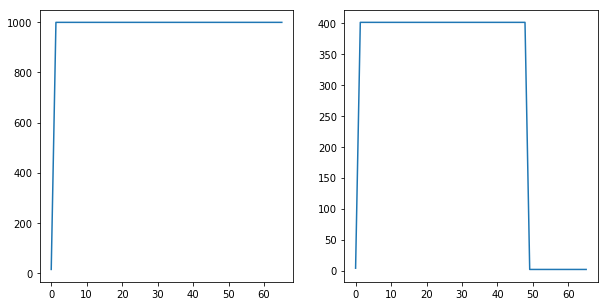

In [107]:
zm_niters=zm_df.astype(float).groupby(['beta'])['niters'].mean()
niters=rm_df.astype(float).groupby(['beta'])['niters'].mean()

plt.close()
f,a=plt.subplots(1,2,figsize=(10,5))

a=plt.subplot(1,2,1)
a.set_xlabel("",fontsize=14)
a.set_ylabel("",fontsize=14)
a.set_title("",fontsize=18)
a.plot(zm_niters.index,zm_niters.values)
a=plt.subplot(1,2,2)
a.set_xlabel("",fontsize=14)
a.set_ylabel("",fontsize=14)
a.set_title("",fontsize=18)
a.plot(niters.index,niters.values)

plt.show()

In [112]:
mbp_obj.retrieval_modularities

,q,beta,resgamma,omega,retrieval_modularity,niters,converged,bethe_free_energy,avg_entropy,num_coms,bstar,is_trivial,non_trivial_converged
0,2.0,0.001000,1.0,0.0,0.004633,4.0,True,-2.785199,1.000000,2.0,0.995707,True,0
1,2.0,1.327510,1.0,0.0,0.183021,401.0,False,-5.123275,0.832514,2.0,0.995707,False,0
2,2.0,2.654020,1.0,0.0,0.143387,401.0,False,-9.749247,0.454073,2.0,0.995707,False,0
3,2.0,3.980531,1.0,0.0,0.116570,401.0,False,-15.611161,0.275625,2.0,0.995707,False,0
4,2.0,5.307041,1.0,0.0,0.190933,401.0,False,-20.246181,0.154475,2.0,0.995707,False,0
5,2.0,6.633551,1.0,0.0,0.160916,401.0,False,-25.314882,0.200902,2.0,0.995707,False,0
6,2.0,7.960061,1.0,0.0,0.148014,401.0,False,-32.359012,0.114092,2.0,0.995707,False,0
7,2.0,9.286571,1.0,0.0,0.152640,401.0,False,-37.122339,0.113017,2.0,0.995707,False,0
8,2.0,10.613082,1.0,0.0,0.181243,401.0,False,-40.418554,0.106020,2.0,0.995707,False,0
9,2.0,11.939592,1.0,0.0,0.177376,401.0,False,-42.596373,0.088743,2.0,0.995707,False,0
